train autoencoder WITHOUT using 1DCNN roi finder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from PyPDF2 import PdfMerger
import os
from tensorflow.keras.models import load_model
import pp_large_samples as pp

2023-05-30 15:39:18.767454: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 15:39:19.018599: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 15:39:19.221870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 15:39:19.225437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 15:39:30.156278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
%who

ColumnTransformer	 PdfMerger	 StandardScaler	 isfile	 join	 keras	 listdir	 load_model	 make_column_transformer	 
np	 os	 pd	 plt	 pp	 shuffle	 sys	 tf	 train_test_split	 



### Load and split data

In [3]:
wireplane = "Z"
np.random.seed(77)
path = '/home/vlian/Workspace/processed_ar39/'

In [4]:
dataset = np.load(path+'Sample_'+wireplane+'_Plane.npy', allow_pickle=True)

In [5]:
mins_ = [max(abs(wave)) for wave in dataset[0][0][1]]

In [6]:
min(mins_)

5

In [7]:
del mins_

In [8]:
pp.group_num_labels

{0: 'adc_5_7',
 1: 'adc_8_10',
 2: 'adc_11_13',
 3: 'adc_14_16',
 4: 'adc_17_19',
 5: 'adc_20_22',
 6: 'adc_gt_22'}

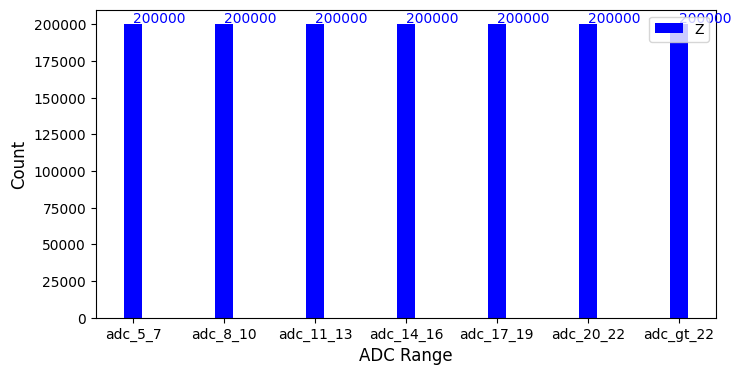

In [9]:
fig = plt.figure(figsize=(8,4))
x_labels = [pp.group_num_labels[i] for i in range(7)]
bar_width = 0.2

plt.bar([i for i in range(7)], dataset[1], width=bar_width, color='blue', label=wireplane)

for i in range(7):
    dist = 1000
    plt.text(i, dataset[1][i] + dist, dataset[1][i], color='blue', size=10)

plt.xticks([i for i in range(7)], x_labels)
plt.legend()
plt.xlabel('ADC Range', size=12)
plt.ylabel('Count', size=12)
plt.show()

### get additonal samples for adc_gt_21 from NU_CC and NU_ES

In [10]:
test_min = [max(abs(wave)) for wave in dataset[0][4][1]]

In [11]:
len(test_min)

200000

In [12]:
min(test_min)

17

In [13]:
del test_min

In [14]:
path = '/home/vlian/Workspace/train_dune_lartpc_v2/'
nticks = 200
ADC_MIN = 15
signal_waveforms, clean_signal_waveforms, noise_waveforms, noiseless_waveform = pp.process_data(wireplane=wireplane, path=path, ADC_MIN=ADC_MIN)

for i in range(10):
    signal_waveforms, clean_signal_waveforms = shuffle(signal_waveforms, clean_signal_waveforms)

nu_cc:  /home/vlian/Workspace/train_dune_lartpc_v2/nu_cc/
nu_es:  /home/vlian/Workspace/train_dune_lartpc_v2/nu_es/
noise:  /home/vlian/Workspace/more-noise/

----------loading----------
--------data loaded!-------
---------------------------------
     signal+noise:  224270
     clean signal:  224270
     noise       :  1400000
---------------------------------

filtering out small signals --> ADC > 15
     noise+signal :  (224270, 200)
     clean signal :  (224270, 200)
------------after filtering------------
     noise+signal :  (106761, 200)
     clean signal :  (106761, 200)


In [15]:
nu_es_cc_grouped_by_ADC = pp.adc_grouping(signal_waveforms, clean_signal_waveforms)
nu_es_cc_grouped_by_ADC = np.array(nu_es_cc_grouped_by_ADC, dtype=object)
for_combining = nu_es_cc_grouped_by_ADC[:, :7]

 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22           

adc_5_7
count       0

adc_8_10
count       0

adc_11_13
count       0

adc_14_16
count       4385

adc_17_19
count       5425

adc_20_22
count       4199

adc_gt_22
count       92752

     Total:    106761


In [16]:
print(dataset.shape, for_combining.shape)

(2, 7) (2, 7)


In [17]:
waves_idx = 0
count_idx = 1
x_idx = 0
y_idx= 1

adc_grp = 6

# dataset[waves_idx][adc_group_idx][x_idx]

In [18]:
print(type(dataset[waves_idx][adc_grp][x_idx]),
            type(for_combining[waves_idx][adc_grp][x_idx]))

<class 'list'> <class 'list'>


In [19]:
print(len(dataset[waves_idx][adc_grp][x_idx]),
            len(for_combining[waves_idx][adc_grp][x_idx]))

200000 92752


In [20]:
for i in range(7):
    print(len(dataset[waves_idx][i][x_idx]), dataset[count_idx][i])

200000 200000
200000 200000
200000 200000
200000 200000
200000 200000
200000 200000
200000 200000


In [21]:
# sudo code
for adc_group_idx in range(7):
    if len(for_combining[waves_idx][adc_group_idx][x_idx]) > 0 and len(dataset[waves_idx][adc_group_idx][y_idx]) < 200000:
        dataset[waves_idx][adc_group_idx][x_idx] += for_combining[waves_idx][adc_group_idx][x_idx]
        dataset[waves_idx][adc_group_idx][y_idx] += for_combining[waves_idx][adc_group_idx][y_idx]
        
        print('Debug: ', len(dataset[waves_idx][adc_group_idx][x_idx]), len(for_combining[waves_idx][adc_group_idx][x_idx]))
        
        dataset[count_idx][adc_group_idx] += len(for_combining[waves_idx][adc_group_idx][x_idx])



In [22]:
len(dataset[waves_idx][6][y_idx])

200000

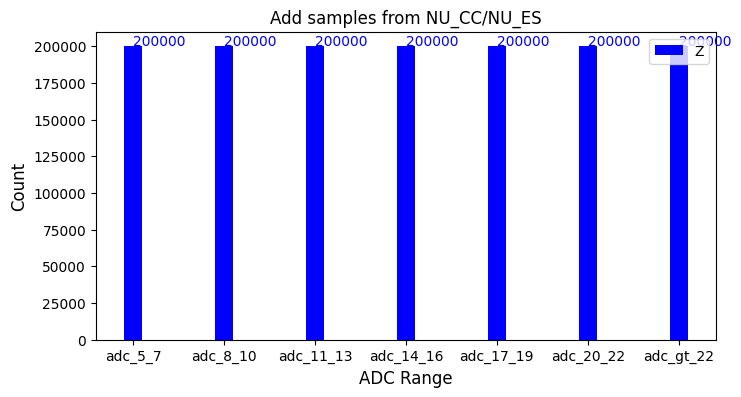

In [23]:
fig = plt.figure(figsize=(8,4))
x_labels = [pp.group_num_labels[i] for i in range(7)]
bar_width = 0.2

plt.bar([i for i in range(7)], dataset[1], width=bar_width, color='blue', label=wireplane)
plt.title('Add samples from NU_CC/NU_ES')

for i in range(7):
    dist = 1000
    plt.text(i, dataset[1][i] + dist, dataset[1][i], color='blue', size=10)

plt.xticks([i for i in range(7)], x_labels)
plt.legend()
plt.xlabel('ADC Range', size=12)
plt.ylabel('Count', size=12)
plt.show()

In [28]:
dataset_to_train_small_adc_x = []
dataset_to_train_small_adc_y = []
adc_group_idx = 0
for adc_group_idx in range(2):
    print(adc_group_idx, len(dataset[waves_idx][adc_group_idx][x_idx]))
    dataset_to_train_small_adc_x += dataset[waves_idx][adc_group_idx][x_idx]
    dataset_to_train_small_adc_y += dataset[waves_idx][adc_group_idx][y_idx]
    print(len(dataset_to_train_small_adc_x), len(dataset_to_train_small_adc_y))

0 200000
200000 200000
1 200000
400000 400000


In [29]:
(len(dataset_to_train_small_adc_y))

400000

In [30]:
pp.group_num_labels

{0: 'adc_5_7',
 1: 'adc_8_10',
 2: 'adc_11_13',
 3: 'adc_14_16',
 4: 'adc_17_19',
 5: 'adc_20_22',
 6: 'adc_gt_22'}

In [31]:
dataset_to_train_small_adc_grouping = pp.adc_grouping(dataset_to_train_small_adc_x, dataset_to_train_small_adc_y)

 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22           

adc_5_7
count       200000

adc_8_10
count       200000

adc_11_13
count       0

adc_14_16
count       0

adc_17_19
count       0

adc_20_22
count       0

adc_gt_22
count       0

     Total:    400000


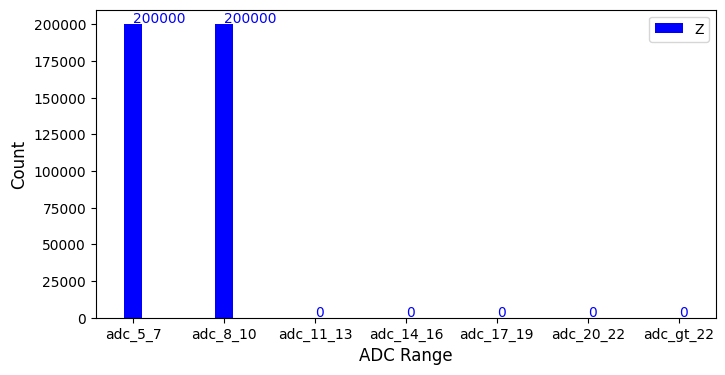

In [32]:
fig = plt.figure(figsize=(8,4))
x_labels = [pp.group_num_labels[i] for i in range(7)]
bar_width = 0.2

plt.bar([i for i in range(7)], dataset_to_train_small_adc_grouping[1], width=bar_width, color='blue', label=wireplane)

for i in range(7):
    dist = 1000
    plt.text(i, dataset_to_train_small_adc_grouping[1][i] + dist, dataset_to_train_small_adc_grouping[1][i], color='blue', size=10)

plt.xticks([i for i in range(7)], x_labels)
plt.legend()
plt.xlabel('ADC Range', size=12)
plt.ylabel('Count', size=12)
plt.show()

In [33]:
print(len(dataset_to_train_small_adc_x), len(dataset_to_train_small_adc_y))

400000 400000


### Shuffle dataset

In [34]:
for i in range(10):
    dataset_to_train_small_adc_x, dataset_to_train_small_adc_y = shuffle(dataset_to_train_small_adc_x, dataset_to_train_small_adc_y)

### Split data

In [35]:
dataset_to_train_small_adc_x_train, dataset_to_train_small_adc_x_test, dataset_to_train_small_adc_y_train, dataset_to_train_small_adc_y_test = train_test_split(dataset_to_train_small_adc_x, dataset_to_train_small_adc_y, test_size=0.5, shuffle=True)

In [45]:
print(len(dataset_to_train_small_adc_x_train))

200000


### get noise samples

In [46]:
noise_waveforms = noise_waveforms[:len(dataset_to_train_small_adc_x_train)*2]
noiseless_waveform = noiseless_waveform[:len(dataset_to_train_small_adc_x_train)*2]

In [47]:
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(noise_waveforms, noiseless_waveform, test_size=0.5, shuffle=True)

In [48]:
print(len(x_noise_train), len(x_noise_test))

200000 200000


In [49]:
for i in range(10):
    dataset_to_train_small_adc_x_train, dataset_to_train_small_adc_y_train = shuffle(dataset_to_train_small_adc_x_train, dataset_to_train_small_adc_y_train)
    dataset_to_train_small_adc_x_test, dataset_to_train_small_adc_y_test = shuffle(dataset_to_train_small_adc_x_test, dataset_to_train_small_adc_y_test)
    x_noise_train, y_noise_train = shuffle(x_noise_train, y_noise_train)
    x_noise_test, y_noise_test = shuffle(x_noise_test, y_noise_test)

In [50]:
x_train = np.concatenate((dataset_to_train_small_adc_x_train, x_noise_train))
y_train = np.concatenate((dataset_to_train_small_adc_y_train, y_noise_train))

x_test = np.concatenate((dataset_to_train_small_adc_x_test, x_noise_test))
y_test = np.concatenate((dataset_to_train_small_adc_y_test, y_noise_test))

In [51]:
for i in range(10):
    x_train, y_train = shuffle(x_train, y_train)
    x_test, y_test = shuffle(x_test, y_test)

### training validation split

In [52]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=False
)

In [56]:
len(x_test)

400000

In [57]:
train_set = pp.adc_grouping(x_train, y_train)
test_set = pp.adc_grouping(x_test, y_test)
val_set = pp.adc_grouping(x_valid, y_valid)

 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22           

adc_5_7
count       80162

adc_8_10
count       80062

adc_11_13
count       0

adc_14_16
count       0

adc_17_19
count       0

adc_20_22
count       0

adc_gt_22
count       0

     Total:    160224
 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22           

adc_5_7
count       100034

adc_8_10
count       99966

adc_11_13
count       0

adc_14_16
count       0

adc_17_19
count       0

adc_20_22
count       0

adc_gt_22
count       0

     Total:    200000
 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22           

adc_5_7
count       19804

adc_8_10
count       19972

adc_11_13
count      

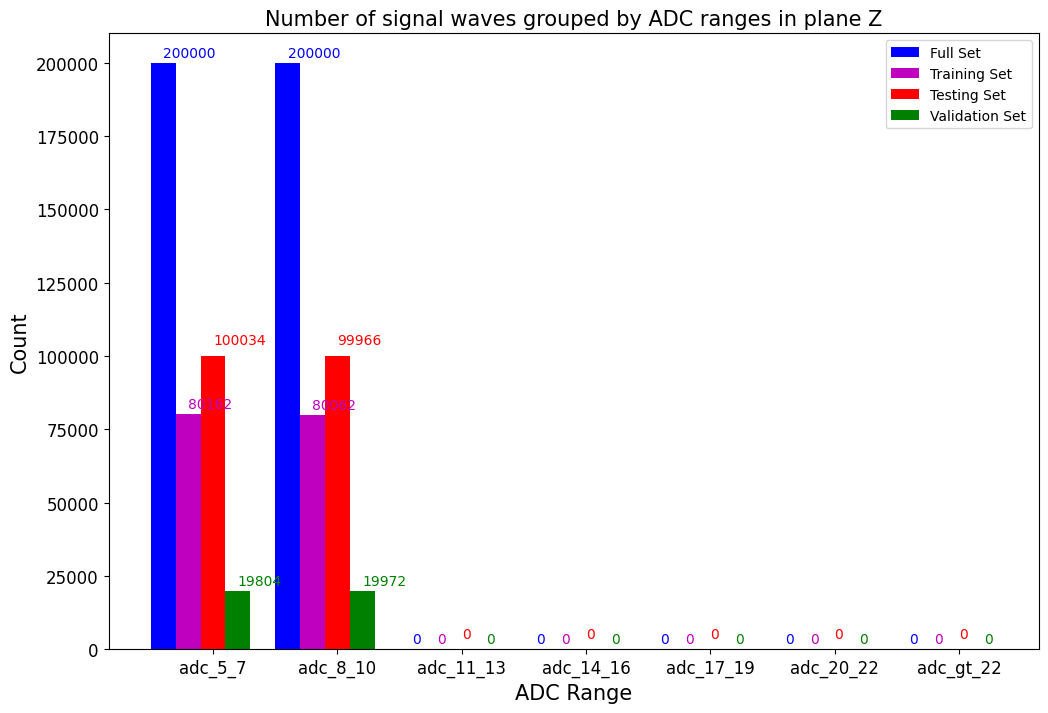

In [58]:
fig = plt.figure(figsize=(12,8))
plt.title('Number of signal waves grouped by ADC ranges in plane ' + wireplane, size=15)

x_labels = [pp.group_num_labels[i] for i in range(7)]
bar_width = 0.2

plt.bar([i - 2*bar_width for i in range(7)], dataset_to_train_small_adc_grouping[1], width=bar_width, color='blue', label='Full Set')
plt.bar([i - bar_width for i in range(7)], train_set[1], width=bar_width, color='m', label='Training Set')
plt.bar([i for i in range(7)], test_set[1], width=bar_width, color='r', label='Testing Set')
plt.bar([i + bar_width for i in range(7)], val_set[1], width=bar_width, color='green', label='Validation Set')

for i in range(7):
    dist = 2000
    plt.text(i - 2*bar_width, dataset_to_train_small_adc_grouping[1][i] + dist, dataset_to_train_small_adc_grouping[1][i], color='blue')
    plt.text(i - bar_width, train_set[1][i] + dist, train_set[1][i], color='m')
    plt.text(i, test_set[1][i] + 2*dist, test_set[1][i], color='r')
    plt.text(i + bar_width, val_set[1][i] + dist, val_set[1][i], color='g')


plt.xticks([i for i in range(7)], x_labels, size=12)
plt.yticks(size=12)
plt.legend()
plt.xlabel('ADC Range', size=15)
plt.ylabel('Count', size=15)
plt.show()

In [59]:
mean = x_train.mean()
std = x_train.std()

In [60]:
np.save('./results/low_adc_'+wireplane+'_mean_adc_5_10', mean)
np.save('./results/low_adc_'+wireplane+'_std_adc_5_10', std)
np.save('./results/low_adc_'+wireplane+'_x_train_adc_5_10', x_train)
np.save('./results/low_adc_'+wireplane+'_y_train_adc_5_10', y_train)
np.save('./results/low_adc_'+wireplane+'_x_test_adc_5_10', x_test)
np.save('./results/low_adc_'+wireplane+'_y_test_adc_5_10', y_test)
np.save('./results/low_adc_'+wireplane+'_x_valid_adc_5_10', x_valid)
np.save('./results/low_adc_'+wireplane+'_y_valid_adc_5_10', y_valid)

In [61]:
x_train_scaled = (x_train-mean)/std
x_test_scaled = (x_test-mean)/std
x_valid_scaled = (x_valid-mean)/std

y_train_scaled = (y_train-mean)/std
y_test_scaled = (y_test-mean)/std
y_valid_scaled = (y_valid-mean)/std

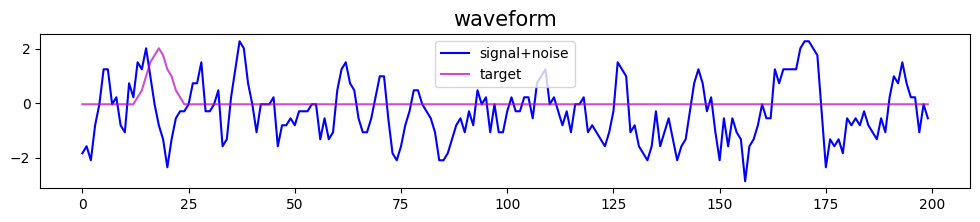

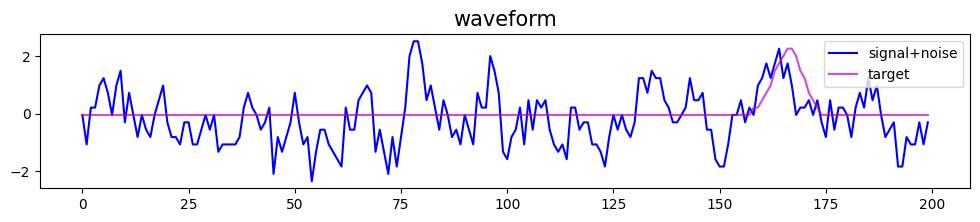

In [66]:
for idx in range(1,3):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization
#from keras import backend as K

In [68]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1DTranspose

In [69]:
time_periods = 200
autoencoder = Sequential()
# encoder
autoencoder.add(Conv1D(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu", input_shape=(time_periods,1)))
autoencoder.add(Conv1D(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1D(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))

# decoder
autoencoder.add(Conv1DTranspose(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu"))

autoencoder.add(Conv1DTranspose(filters=1, kernel_size=3, padding="same"))

autoencoder.compile(loss='mse', optimizer='adam')


In [70]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            2592      
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             18496     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 25, 64)           36928     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          10272     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 200, 16)          1

In [71]:
for i,layer in enumerate(autoencoder.layers):                                      
    print(i,layer.name)

0 conv1d
1 conv1d_1
2 conv1d_2
3 conv1d_transpose
4 conv1d_transpose_1
5 conv1d_transpose_2
6 conv1d_transpose_3


In [72]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [73]:
%who

ADC_MIN	 AveragePooling1D	 BatchNormalization	 ColumnTransformer	 Conv1D	 Conv1DTranspose	 Dense	 Dropout	 Flatten	 
GlobalAveragePooling1D	 GlobalMaxPooling1D	 Input	 MaxPooling1D	 Model	 PdfMerger	 Reshape	 Sequential	 StandardScaler	 
UpSampling1D	 adc_group_idx	 adc_grp	 autoencoder	 ax1	 bar_width	 clean_signal_waveforms	 count_idx	 dataset	 
dataset_to_train_small_adc_grouping	 dataset_to_train_small_adc_x	 dataset_to_train_small_adc_x_test	 dataset_to_train_small_adc_x_train	 dataset_to_train_small_adc_y	 dataset_to_train_small_adc_y_test	 dataset_to_train_small_adc_y_train	 dist	 earlystop	 
fig	 for_combining	 i	 idx	 isfile	 join	 keras	 layer	 listdir	 
load_model	 make_column_transformer	 mean	 noise_waveforms	 noiseless_waveform	 np	 nticks	 nu_es_cc_grouped_by_ADC	 os	 
path	 pd	 plt	 pp	 shuffle	 signal_waveforms	 std	 sys	 test_set	 
tf	 time_periods	 train_set	 train_test_split	 val_set	 waves_idx	 wireplane	 x_idx	 x_labels	 
x_noise_test	 x_noise_train	 x_test	 x_tes

In [74]:
del dataset, dataset_to_train_small_adc_grouping, dataset_to_train_small_adc_x, dataset_to_train_small_adc_x_test
del clean_signal_waveforms, dataset_to_train_small_adc_x_train, dataset_to_train_small_adc_y, dataset_to_train_small_adc_y_test
del dataset_to_train_small_adc_y_train, for_combining, signal_waveforms, test_set, train_set, val_set, y_train, y_valid

In [75]:
%who

ADC_MIN	 AveragePooling1D	 BatchNormalization	 ColumnTransformer	 Conv1D	 Conv1DTranspose	 Dense	 Dropout	 Flatten	 
GlobalAveragePooling1D	 GlobalMaxPooling1D	 Input	 MaxPooling1D	 Model	 PdfMerger	 Reshape	 Sequential	 StandardScaler	 
UpSampling1D	 adc_group_idx	 adc_grp	 autoencoder	 ax1	 bar_width	 count_idx	 dist	 earlystop	 
fig	 i	 idx	 isfile	 join	 keras	 layer	 listdir	 load_model	 
make_column_transformer	 mean	 noise_waveforms	 noiseless_waveform	 np	 nticks	 nu_es_cc_grouped_by_ADC	 os	 path	 
pd	 plt	 pp	 shuffle	 std	 sys	 tf	 time_periods	 train_test_split	 
waves_idx	 wireplane	 x_idx	 x_labels	 x_noise_test	 x_noise_train	 x_test	 x_test_scaled	 x_train	 
x_train_scaled	 x_valid	 x_valid_scaled	 y_idx	 y_noise_test	 y_noise_train	 y_test	 y_test_scaled	 y_train_scaled	 
y_valid_scaled	 


In [76]:
del noiseless_waveform, nu_es_cc_grouped_by_ADC, x_train, x_valid

In [77]:
%who

ADC_MIN	 AveragePooling1D	 BatchNormalization	 ColumnTransformer	 Conv1D	 Conv1DTranspose	 Dense	 Dropout	 Flatten	 
GlobalAveragePooling1D	 GlobalMaxPooling1D	 Input	 MaxPooling1D	 Model	 PdfMerger	 Reshape	 Sequential	 StandardScaler	 
UpSampling1D	 adc_group_idx	 adc_grp	 autoencoder	 ax1	 bar_width	 count_idx	 dist	 earlystop	 
fig	 i	 idx	 isfile	 join	 keras	 layer	 listdir	 load_model	 
make_column_transformer	 mean	 noise_waveforms	 np	 nticks	 os	 path	 pd	 plt	 
pp	 shuffle	 std	 sys	 tf	 time_periods	 train_test_split	 waves_idx	 wireplane	 
x_idx	 x_labels	 x_noise_test	 x_noise_train	 x_test	 x_test_scaled	 x_train_scaled	 x_valid_scaled	 y_idx	 
y_noise_test	 y_noise_train	 y_test	 y_test_scaled	 y_train_scaled	 y_valid_scaled	 


In [78]:
list_ = %who_ls

In [79]:
sum_= 0
for var in list_:
    size_ = sys.getsizeof(var)
    size_in_mb = size_ / (1024 ** 2)
    sum_ =+ sys.getsizeof(size_in_mb)
    #print(sys.getsizeof(var))
sum_

24

In [80]:
batch_size_ = 12800

In [81]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
            y_train_scaled,                                                            
            batch_size=batch_size_,                                              
            epochs=1000,                                                      
            callbacks= [earlystop], #[NewCallback(alpha)], # callbacks=callbacks_list,
            validation_data=(x_valid_scaled, y_valid_scaled),                                                                      
            verbose=1)

Epoch 1/1000
25/25 [==============================] - 143s 6s/step - loss: 0.0445 - val_loss: 0.0322
Epoch 2/1000
25/25 [==============================] - 141s 6s/step - loss: 0.0294 - val_loss: 0.0280
Epoch 3/1000
25/25 [==============================] - 141s 6s/step - loss: 0.0277 - val_loss: 0.0272
Epoch 4/1000
25/25 [==============================] - 141s 6s/step - loss: 0.0272 - val_loss: 0.0269
Epoch 5/1000
25/25 [==============================] - 141s 6s/step - loss: 0.0269 - val_loss: 0.0267
Epoch 6/1000
25/25 [==============================] - 140s 6s/step - loss: 0.0267 - val_loss: 0.0265
Epoch 7/1000
25/25 [==============================] - 139s 6s/step - loss: 0.0266 - val_loss: 0.0264
Epoch 8/1000
25/25 [==============================] - 140s 6s/step - loss: 0.0265 - val_loss: 0.0263
Epoch 9/1000
25/25 [==============================] - 140s 6s/step - loss: 0.0264 - val_loss: 0.0262
Epoch 10/1000
25/25 [==============================] - 141s 6s/step - loss: 0.0263 - val_lo

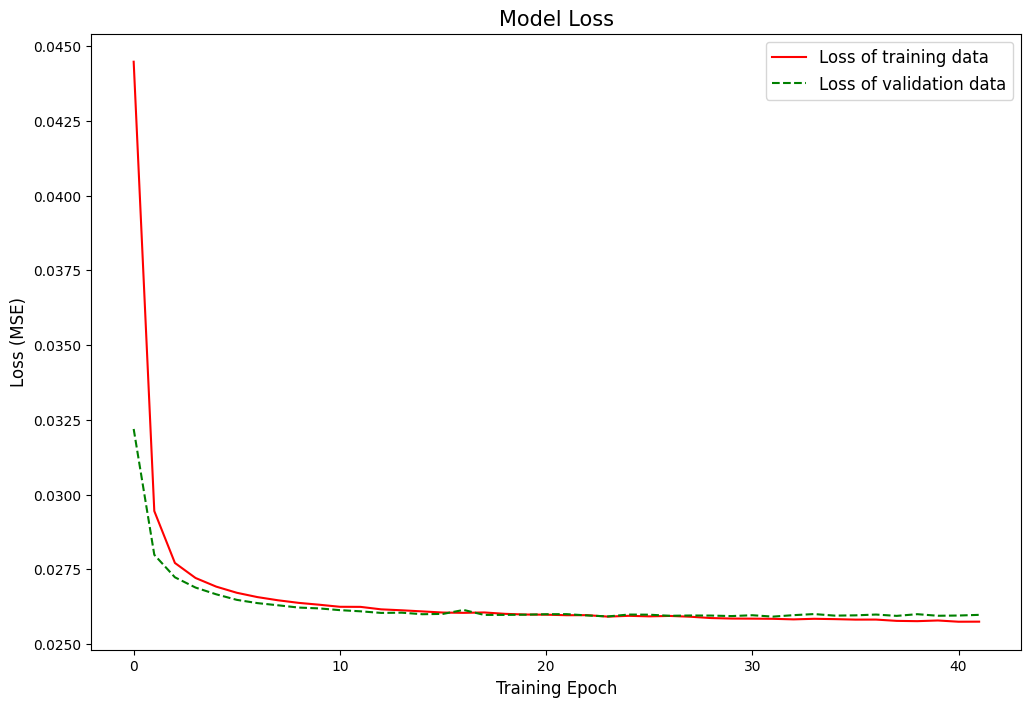

In [82]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "g--", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)                                                                    
plt.show()     

In [83]:
#del x_train

import gc
gc.collect()

46315

In [84]:
autoencoder.save('./models/model_AE_'+str(batch_size_)+'_low_ADC_5_10' + wireplane + 'plane_nu.h5')

In [85]:
#autoencoder = load_model('./models/model_AE_'+str(batch_size_)+'_no_pooling' + wireplane + 'plane_nu.h5')

In [86]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

98/98 [==============================] - 128s 1s/step - loss: 0.0261


0.026070846244692802

In [ ]:
autoencoder.evaluate(x_train_scaled, y_train_scaled, batch_size=4096)

In [ ]:
autoencoder.evaluate(x_valid_scaled, y_valid_scaled, batch_size=4096)

In [ ]:
#ae128 = load_model('./AE_models/model_AE_'+str(batch_size_)+'_mse' + wireplane + 'plane_nu.h5')

In [87]:
%%time
predictions = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])



98/98 [==============================] - 127s 1s/step
CPU times: user 3min 56s, sys: 1min 58s, total: 5min 54s
Wall time: 2min 8s


In [88]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean


pred = predictions*std + mean

200000

In [89]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [90]:
pred_labels = [label_predictions(wave) for wave in pred]
truth_labels = [label_truths(t_wave) for t_wave in y_test_]

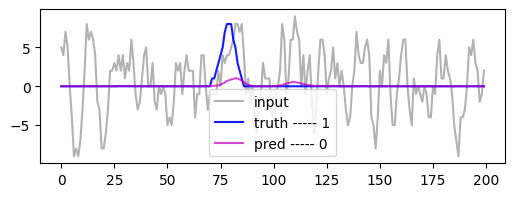

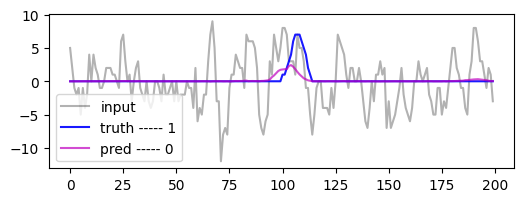

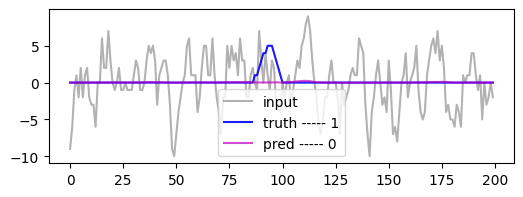

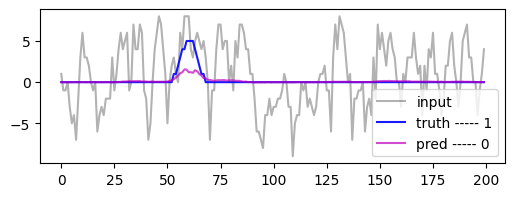

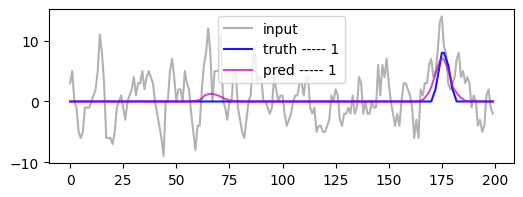

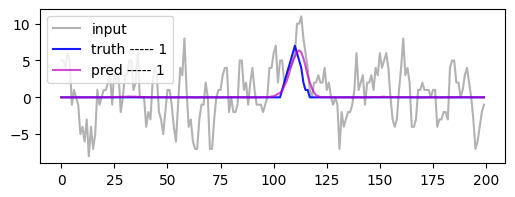

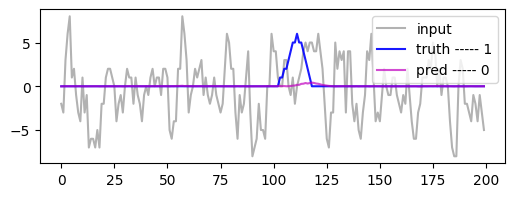

In [91]:
for i in range(100,115):
    if max(abs(y_test_[i])) < 10 and sum(abs(y_test_[i])) !=0:
        fig = plt.figure(figsize=(6,2))
        plt.plot(x_test_[i], color='black', alpha=0.3, label='input')
        plt.plot(y_test_[i], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[i]))
        plt.plot(pred[i], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels[i]))
        plt.legend()
        plt.show()


In [92]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(truth_labels, pred_labels, drop_intermediate=False)
roc_auc = auc(fpr, tpr)


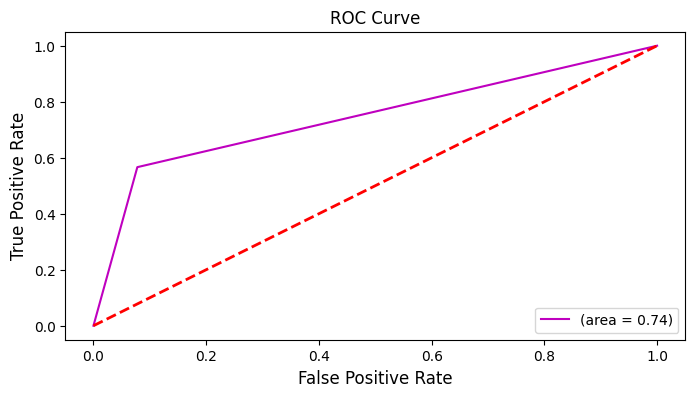

In [93]:
fig = plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='m', label='(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('ROC Curve', size=12)
plt.legend(loc="lower right")
plt.show()

In [156]:
# dataset_x -> noisy signal waveforms
# dataset_y -> clean signal waveforms
# splits data set into subsets based on ADC ranges
def adc_grouping(dataset_x, dataset_y, pred):
    adc_5_7_x = []
    adc_5_7_y = []
    adc_5_7_p = []

    adc_8_10_x = []
    adc_8_10_y = []
    adc_8_10_p = []

    adc_11_13_x = []
    adc_11_13_y = []
    adc_11_13_p = []

    adc_14_16_x = []
    adc_14_16_y = []
    adc_14_16_p = []

    adc_17_19_x = []
    adc_17_19_y = []
    adc_17_19_p = []

    adc_20_22_x = []
    adc_20_22_y = []
    adc_20_22_p = []

    adc_gt_22_x = []
    adc_gt_22_y = []
    adc_gt_22_p = []

    noise_x = []
    noise_y = []
    noise_p = []

    for i, wave in enumerate(dataset_y):
        max_adc = max(abs(wave))
        if sum(abs(wave)) == 0:
            noise_x.append(x_test_[i])
            noise_y.append(wave)
            noise_p.append(pred[i])
        elif max_adc >= 5 and max_adc <= 7:
            adc_5_7_x.append(dataset_x[i])
            adc_5_7_y.append(wave)
            adc_5_7_p.append(pred[i])

        elif max_adc >= 8 and max_adc <= 10:
            adc_8_10_x.append(dataset_x[i])
            adc_8_10_y.append(wave)
            adc_8_10_p.append(pred[i])
        elif max_adc >= 11 and max_adc <= 13:
            adc_11_13_x.append(dataset_x[i])
            adc_11_13_y.append(wave)
            adc_11_13_p.append(pred[i])
        elif max_adc >= 14 and max_adc <= 16:
            adc_14_16_x.append(dataset_x[i])
            adc_14_16_y.append(wave)
            adc_14_16_p.append(pred[i])
        elif max_adc >= 17 and max_adc <= 19:
            adc_17_19_x.append(dataset_x[i])
            adc_17_19_y.append(wave)
            adc_17_19_p.append(pred[i])
        elif max_adc >= 20 and max_adc <= 22:
            adc_20_22_x.append(dataset_x[i])
            adc_20_22_y.append(wave)
            adc_20_22_p.append(pred[i])
        elif max_adc > 22:
            adc_gt_22_x.append(dataset_x[i])
            adc_gt_22_y.append(wave)
            adc_gt_22_p.append(pred[i])

    grouped_waves = [
                    [adc_5_7_x, adc_5_7_y, adc_5_7_p],
                    [adc_8_10_x, adc_8_10_y, adc_8_10_p],
                    [adc_11_13_x, adc_11_13_y, adc_11_13_p],
                    [adc_14_16_x, adc_14_16_y, adc_14_16_p],
                    [adc_17_19_x, adc_17_19_y, adc_17_19_p],
                    [adc_20_22_x, adc_20_22_y, adc_20_22_p],
                    [adc_gt_22_x, adc_gt_22_y, adc_gt_22_p],
                    [noise_x, noise_y, noise_p]  
                    ]
    print(' 0: adc_5_7 \
            1: adc_8_10 \
            2: adc_11_13 \
            3: adc_14_16 \
            4: adc_17_19 \
            5: adc_20_22 \
            6: adc_gt_22\
            7: noise')
    print()
    

    return grouped_waves

group_num_labels = {
                    0: 'adc_5_7',
                    1: 'adc_8_10',
                    2: 'adc_11_13',
                    3: 'adc_14_16',
                    4: 'adc_17_19',
                    5: 'adc_20_22',
                    6: 'adc_gt_22',
                    7: 'noise'
                    }

# prints summary
def print_counts(data_x, data_y, pred):
    grouped = adc_grouping(data_x, data_y, pred)
    sum_ = 0
    
    res = []
    for i in range(8):
        count = len(grouped[i][0])
        print(group_num_labels[i])
        print('{:<12}{}'.format('count', count))
        print()
        res.append(count)
        if i < 7:
            sum_ += count

    print('{:<15}{}'.format('     signal:', sum_))
    print('{:<15}{}'.format('     noise:', len(grouped[7][0])))
    print('{:<15}{}'.format('     TOTAL', sum_+len(grouped[7][0])))

    return res

In [171]:
grouped_waves = adc_grouping(x_test, y_test, pred)

 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22            7: noise



In [175]:
len(grouped_waves[1][0])

99966

In [176]:
print_counts(x_test, y_test, pred)

 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22            7: noise

adc_5_7
count       100034

adc_8_10
count       99966

adc_11_13
count       0

adc_14_16
count       0

adc_17_19
count       0

adc_20_22
count       0

adc_gt_22
count       0

noise
count       200000

     signal:   200000
     noise:    200000
     TOTAL     400000


[100034, 99966, 0, 0, 0, 0, 0, 200000]

In [177]:
def make_single_pdf(wave_idx, pg_num, group_num):

    fig, axs = plt.subplots(3,2, figsize=(20, 12), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        wave_idx = index_


        axes[i].set_title('clean sig. +peak amplitude: ' + str(int(max(grouped_waves[group_num][1][index_]))),size=15)
        axes[i].plot(grouped_waves[group_num][0][index_], color='black', alpha=0.3, label='input')
        axes[i].plot(grouped_waves[group_num][1][index_], color='blue', alpha=0.9, label='truth')
        axes[i].plot(grouped_waves[group_num][2][index_], color='m', alpha=0.7, label='pred')
        axes[i].legend(fontsize=12)
    


    plt.savefig('./plots/tmp/tmp' +str(pg_num) + '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [178]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, group_num):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, group_num) + 1
        page_num += 1

    merger = PdfMerger()
    path = './plots/tmp/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.write('./plots/'+wireplane+'/plane_' + wireplane + '_' + group_num_labels[group_num] + '.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

['./plots/tmp/tmp10.pdf', './plots/tmp/tmp11.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp14.pdf', './plots/tmp/tmp7.pdf', './plots/tmp/tmp2.pdf', './plots/tmp/tmp0.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp3.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp6.pdf', './plots/tmp/tmp8.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp1.pdf']
['./plots/tmp/tmp10.pdf', './plots/tmp/tmp11.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp14.pdf', './plots/tmp/tmp7.pdf', './plots/tmp/tmp2.pdf', './plots/tmp/tmp0.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp3.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp6.pdf', './plots/tmp/tmp8.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp1.pdf']


IndexError: list index out of range

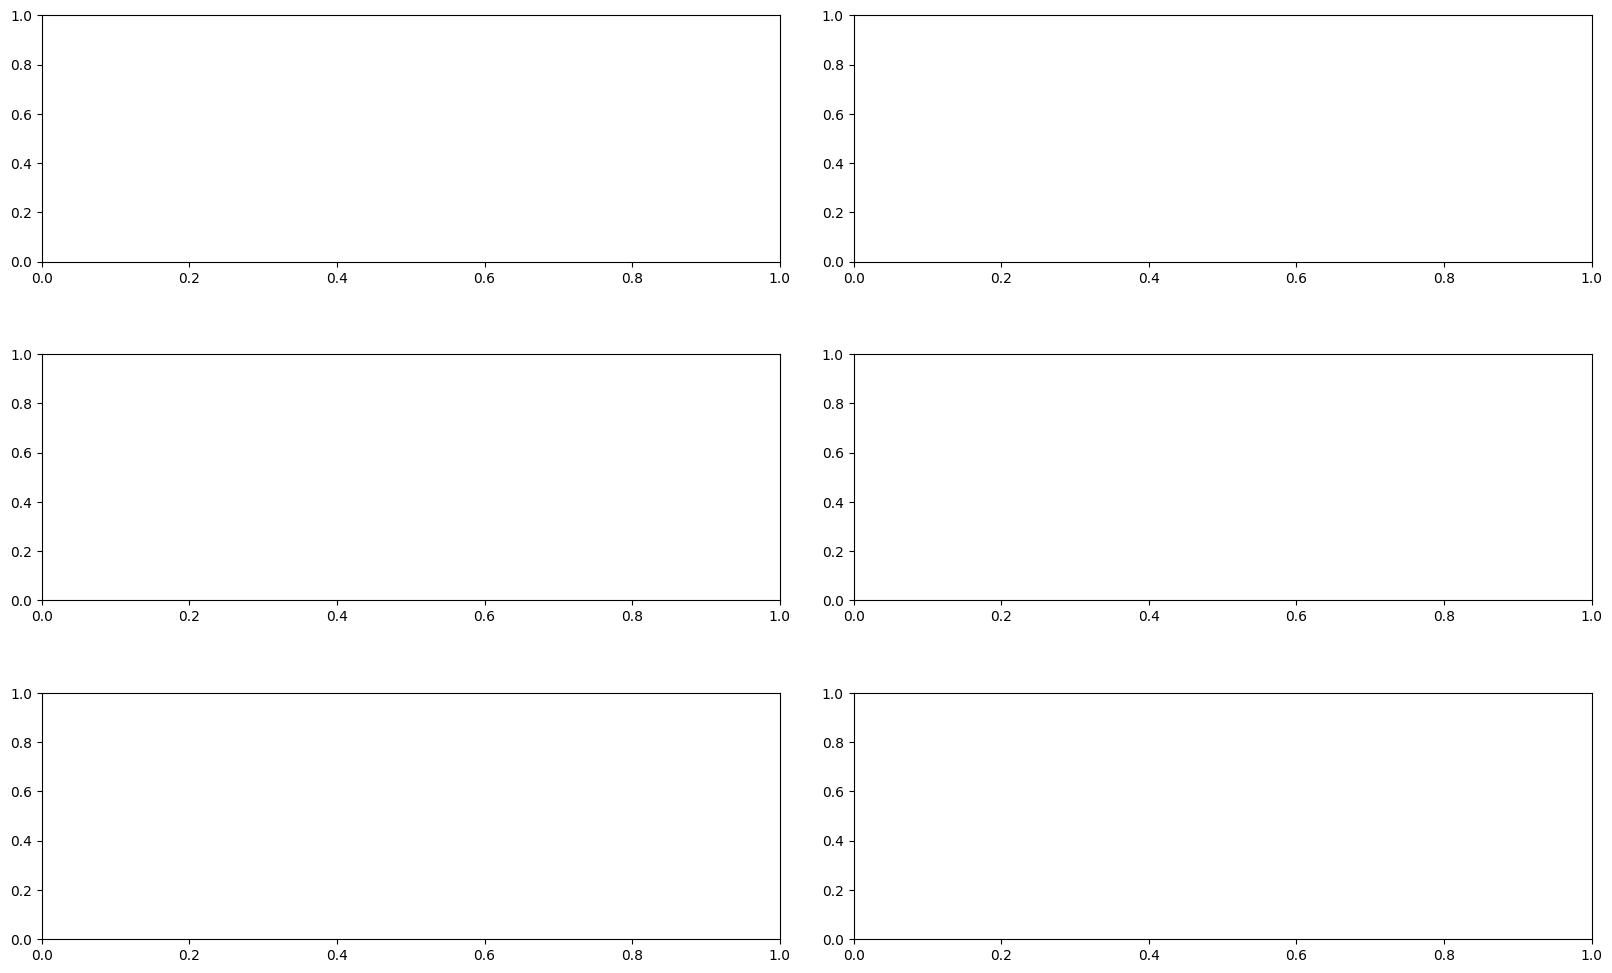

In [179]:
for i in range(4):
    make_complete_pdf(15, i)

Rejection rate at each group

In [180]:
def eval_group(group_num):
    if group_num > 4:
        print('arg should be less than 6')
        return -1
    x = grouped_waves[group_num][0]
    y = grouped_waves[group_num][1]
    infer = grouped_waves[group_num][2]

    positive_x = []
    positive_y = []
    positive_p = []

    negative_x = []
    negative_y = []
    negative_p = []

    for i, wave in enumerate(infer):
        if max(abs(wave)) > 3:
            positive_x.append(x[i])
            positive_y.append(y[i])
            positive_p.append(wave)
        else:
            negative_x.append(x[i])
            negative_y.append(y[i])
            negative_p.append(wave)
    print(group_num_labels[group_num])
    print('{:<12}{}'.format('Total:', len(x)))
    print('{:<12}{}'.format('True Pos: ', len(positive_x)))
    print('{:<12}{}'.format('False Pos: ', len(negative_x)))
    print()

    return [[positive_x, positive_y, positive_p], [negative_x, negative_y, negative_p]]

In [181]:
for i in range(6):
    eval_group(i)

adc_5_7
Total:      100034
True Pos:   39390
False Pos:  60644

adc_8_10
Total:      99966
True Pos:   73872
False Pos:  26094

adc_11_13
Total:      0
True Pos:   0
False Pos:  0

adc_14_16
Total:      0
True Pos:   0
False Pos:  0

adc_17_19
Total:      0
True Pos:   0
False Pos:  0

arg should be less than 6


In [182]:
len(grouped_waves)

8

In [183]:
noise_p = grouped_waves[7][2]

In [184]:
noise__ = [max(abs(wave)) for wave in noise_p if max(abs(wave)) > 3]

In [185]:
print('{:<12}{}'.format('Total:', len(grouped_waves[7][0])))
print('{:<12}{}'.format('True Neg: ', len(grouped_waves[7][0]) - len(noise__)))
print('{:<12}{}'.format('False Neg: ', len(noise__)))
print()

Total:      200000
True Neg:   184433
False Neg:  15567



In [188]:
grouped_pred_waves = adc_grouping(pred, y_test, pred)

 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22            7: noise



In [189]:
def get_num_TP(group_num):
    if group_num > 6:
        print('arg should be less than 6')
        return -1
    y = grouped_pred_waves[group_num][1]
    infer = grouped_pred_waves[group_num][0]

    positive_y = []
    positive_p = []

    negative_y = []
    negative_p = []

    for i, wave in enumerate(infer):
        if max(abs(wave)) > 3:
            positive_y.append(y[i])
            positive_p.append(wave)
        else:
            negative_y.append(y[i])
            negative_p.append(wave)
    print(group_num_labels[group_num])
    print('{:<12}{}'.format('Total:', len(y)))
    print('{:<12}{}'.format('True Pos: ', len(positive_y)))
    print('{:<12}{}'.format('False Pos: ', len(negative_y)))
    print()

    return len(positive_y)

In [190]:
test_set_TP = []
for i in range(7):
    test_set_TP.append(get_num_TP(i))
    

adc_5_7
Total:      100034
True Pos:   39390
False Pos:  60644

adc_8_10
Total:      99966
True Pos:   73872
False Pos:  26094

adc_11_13
Total:      0
True Pos:   0
False Pos:  0

adc_14_16
Total:      0
True Pos:   0
False Pos:  0

adc_17_19
Total:      0
True Pos:   0
False Pos:  0

adc_20_22
Total:      0
True Pos:   0
False Pos:  0

adc_gt_22
Total:      0
True Pos:   0
False Pos:  0



NameError: name 'dataset_to_train_small_adc_grouping' is not defined

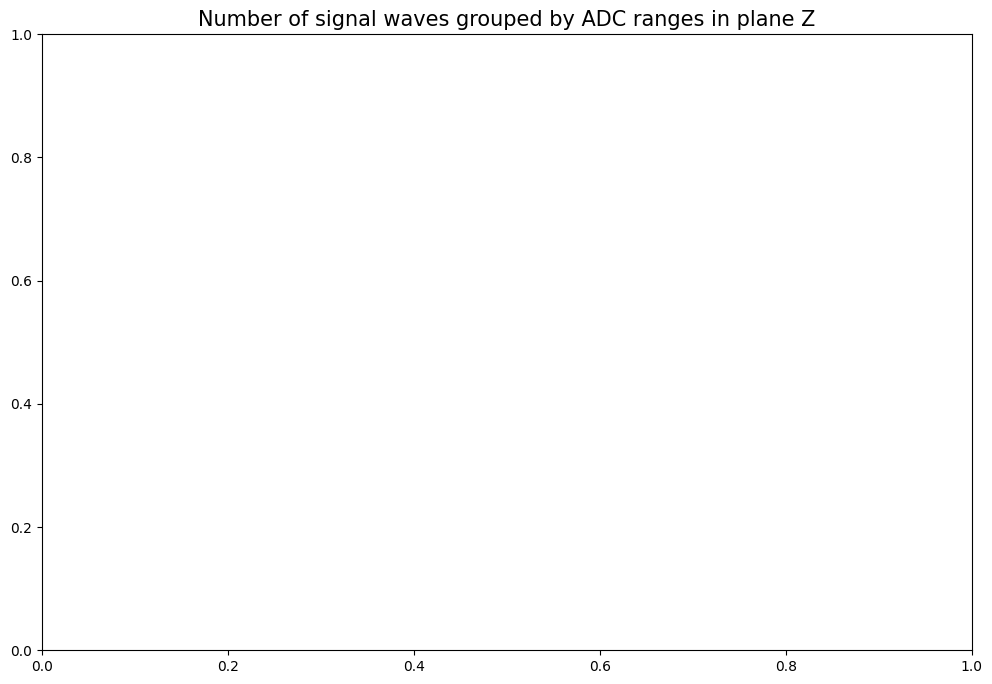

In [191]:
fig = plt.figure(figsize=(12,8))
num_x = 7
plt.title('Number of signal waves grouped by ADC ranges in plane ' + wireplane, size=15)

x_labels = [group_num_labels[i] for i in range(num_x)]
bar_width = 0.1

plt.bar([i - 2*bar_width for i in range(num_x)], dataset_to_train_small_adc_grouping[1][:num_x], width=bar_width, color='blue', label='Full Set')
plt.bar([i - bar_width for i in range(num_x)], train_set[1][:num_x], width=bar_width, color='m', label='Training Set')
plt.bar([i for i in range(num_x)], test_set[1][:num_x], width=bar_width, color='r', label='Testing Set')
plt.bar([i + bar_width for i in range(num_x)], val_set[1][:num_x], width=bar_width, color='green', label='Validation Set')

for i in range(num_x):
    dist = 500
    plt.text(i - 2*bar_width, dataset_to_train_small_adc_grouping[1][i] + dist, dataset_to_train_small_adc_grouping[1][i], color='blue')
    plt.text(i - bar_width, train_set[1][i] + dist, train_set[1][i], color='m')
    plt.text(i, test_set[1][i] + 2*dist, test_set[1][i], color='r')
    plt.text(i + bar_width, val_set[1][i] + dist, val_set[1][i], color='g')

    plt.text(i+bar_width, 140000, 'TPr', size=12)
    plt.text(i+bar_width, 130000, round((test_set_TP[i]/test_set[1][i])*100, 1), size=12)

    #plt.text(1, 17000, 'TPrs are for the testing set', size=12)

plt.xticks([i+bar_width for i in range(num_x)], x_labels, size=12)
plt.yticks(size=12)
plt.legend()
plt.xlabel('ADC Range', size=15)
plt.ylabel('Count', size=15)
plt.show()